In [1]:
!nvidia-smi

Wed Oct  6 15:00:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

colab link

https://colab.research.google.com/drive/1h2WXBtHkh72eV2HkOLLG-OeC_qA28THP?usp=sharing

## install libs

In [1]:
!pip install -qq boto3
!pip install -qq faiss-gpu
!pip install -qq sentence-transformers

     |████████████████████████████████| 131 kB 12.6 MB/s 
     |████████████████████████████████| 79 kB 7.1 MB/s 
     |████████████████████████████████| 8.0 MB 20.3 MB/s 
     |████████████████████████████████| 138 kB 81.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.7 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 89.7 MB 10 kB/s 
     |████████████████████████████████| 78 kB 5.7 MB/s 
     |████████████████████████████████| 2.9 MB 33.1 MB/s 
     |████████████████████████████████| 3.3 MB 70.5 MB/s 
     |████████████████████████████████| 1.2 MB 80.4 MB/s 
     |████████████████████████████████| 56 kB 5.7 MB/s 
     |████████████████████████████████| 636

# input AWS credentials so we can upload indices to S3 bucket

In [3]:
from getpass import getpass
print('Input AWS access key ID:')
aws_access_key_id = getpass()
print('Input AWS secret access key:')
aws_secret_access_key = getpass()

Input AWS access key ID:
··········
Input AWS secret access key:
··········


In [4]:
import boto3

BUCKET_NAME = 'semantic-search-oct21'

s3 = boto3.resource('s3', aws_access_key_id = aws_access_key_id, 
                          aws_secret_access_key= aws_secret_access_key)
my_bucket = s3.Bucket(BUCKET_NAME)

In [5]:
for my_bucket_object in my_bucket.objects.all():
    print(my_bucket_object)

s3.ObjectSummary(bucket_name='semantic-search-oct21', key='artifacts.zip')
s3.ObjectSummary(bucket_name='semantic-search-oct21', key='friends_quotes.csv')
s3.ObjectSummary(bucket_name='semantic-search-oct21', key='futurama_quotes.csv')
s3.ObjectSummary(bucket_name='semantic-search-oct21', key='phrases.txt.gz')


In [6]:
%cd /content/
!git clone https://github.com/u-brixton/semantic-search-service.git

/content
Cloning into 'semantic-search-service'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 71 (delta 34), reused 58 (delta 23), pack-reused 0
Unpacking objects: 100% (71/71), done.


# import libs

In [7]:
%cd /content/

/content


In [8]:
%load_ext autoreload
%autoreload 2

In [9]:
import json

import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", 1000)
pd.set_option("display.max_columns", 10)
import gzip
import sys
from pathlib import Path

from tqdm.autonotebook import tqdm

sys.path.append("semantic-search-service")
sys.path.append("semantic-search-service/backend_api")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


# preprocessing data

Let's add two more datasets to use in our service - quotes from transcripts of "Friends" and "Futurama" TV series
Raw data could be found on kaggle:
* https://www.kaggle.com/ryanstonebraker/friends-transcript
* https://www.kaggle.com/josephvm/futurama-seasons-16-transcripts


Dataset that we've been given is already preprocessed, but we need to clean those two new datasets a little bit before we can proceed to build faiss indices

<b> We will not be using preprocessing for our main dataset in the task </b>

We will be using a sentence embedder named <b> all-mpnet-base-v2 </b> from Microsoft, as it significantly outperforms other models both on sentence similarity and semantic Search (screenshot below). Speed on CPU is reasonable enough for us to use it (checked)

My favorite model is actually Universal Sentence Encoder and LabSE from Google, as they are multilingual, but LabSE is very large; USE has much lower embedding quality according to ranking on multiple datasets, so we will use mpnet
https://www.sbert.net/docs/pretrained_models.html


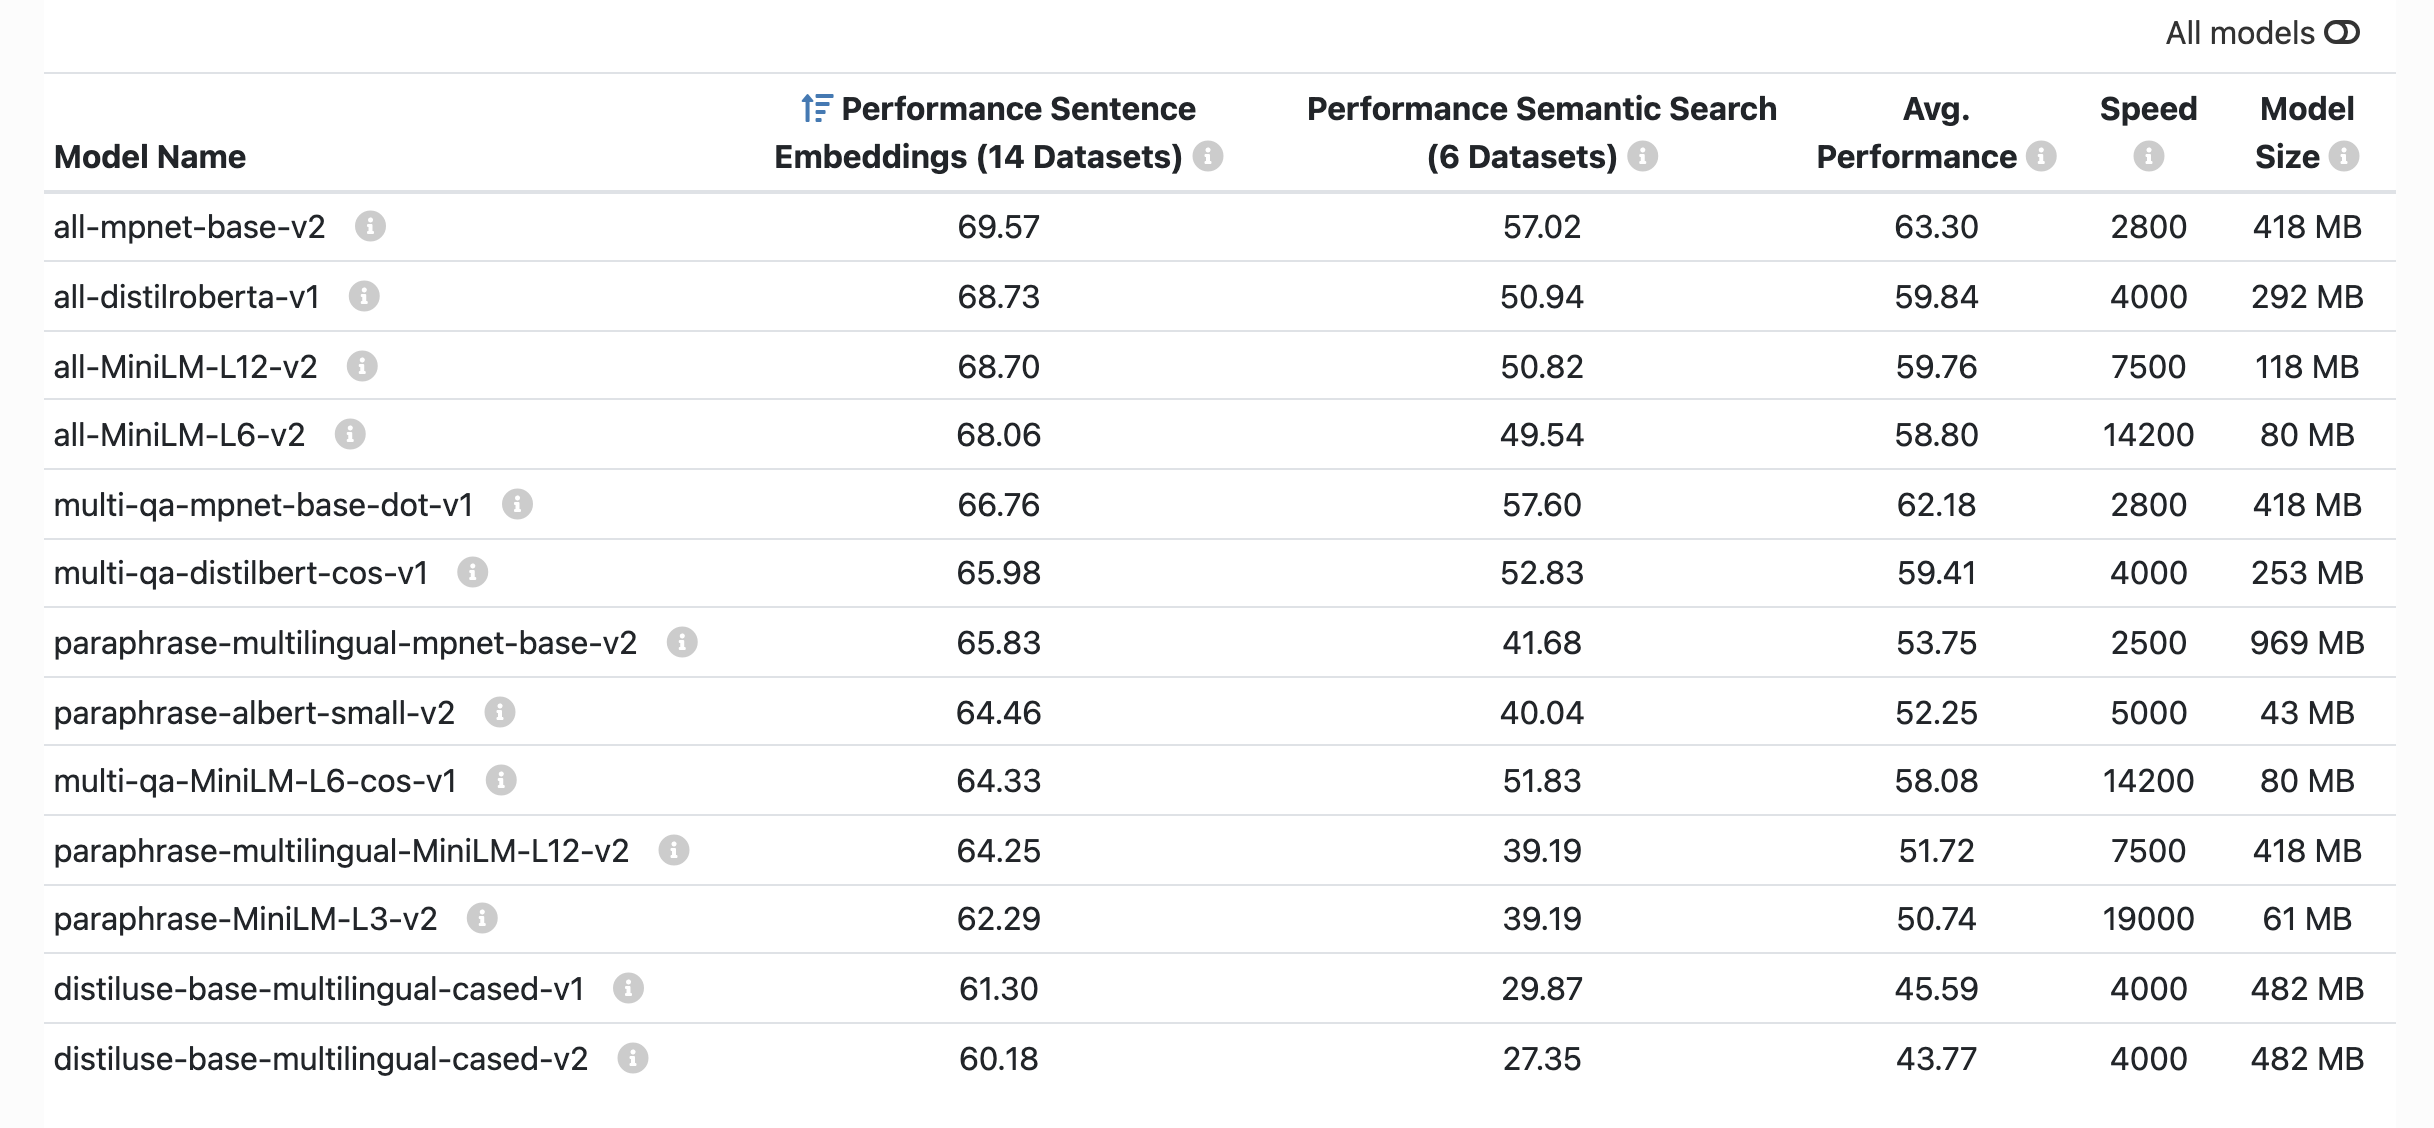

We do not use huggingface hub here but loading weights directly as we would like to download them in docker build file, not during runtime

In [10]:
from utils import unify_dataframe_and_get_stats, preproc_df

In [11]:
model_link = "https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/v0.2/all-mpnet-base-v2.zip"
model_zip_name = "all-mpnet-base-v2.zip"
model_fd = model_zip_name.split(".")[0]

In [12]:
raw_data_path = Path("/content/raw_data")
raw_data_path.mkdir(exist_ok=True)

main_ds_raw_link = "https://semantic-search-oct21.s3.eu-west-1.amazonaws.com/phrases.txt.gz"
friends_raw_link = "https://semantic-search-oct21.s3.eu-west-1.amazonaws.com/friends_quotes.csv"
futurama_raw_link = "https://semantic-search-oct21.s3.eu-west-1.amazonaws.com/futurama_quotes.csv"

main_ds_raw_name = "phrases.txt.gz"
friends_raw_name = friends_raw_link.split("/")[-1]
futurama_raw_name = futurama_raw_link.split("/")[-1]

In [13]:
!wget $model_link -O $model_zip_name
!unzip -o $model_zip_name -d $model_fd

--2021-10-06 18:18:04--  https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/v0.2/all-mpnet-base-v2.zip
Resolving public.ukp.informatik.tu-darmstadt.de (public.ukp.informatik.tu-darmstadt.de)... 130.83.167.186
Connecting to public.ukp.informatik.tu-darmstadt.de (public.ukp.informatik.tu-darmstadt.de)|130.83.167.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 404986460 (386M) [application/zip]
Saving to: ‘all-mpnet-base-v2.zip’

all-mpnet-base-v2.z 100%[===================>] 386.22M   103MB/s    in 4.0s    

2021-10-06 18:18:08 (95.6 MB/s) - ‘all-mpnet-base-v2.zip’ saved [404986460/404986460]

Archive:  all-mpnet-base-v2.zip
   creating: all-mpnet-base-v2/1_Pooling/
  inflating: all-mpnet-base-v2/1_Pooling/config.json  
  inflating: all-mpnet-base-v2/README.md  
  inflating: all-mpnet-base-v2/config.json  
  inflating: all-mpnet-base-v2/config_sentence_transformers.json  
  inflating: all-mpnet-base-v2/data_config.json  
  inflating:

In [14]:
!wget $main_ds_raw_link -O {raw_data_path / main_ds_raw_name}
!wget $friends_raw_link -O {raw_data_path / friends_raw_name}
!wget $futurama_raw_link -O {raw_data_path / futurama_raw_name}

--2021-10-06 18:18:12--  https://semantic-search-oct21.s3.eu-west-1.amazonaws.com/phrases.txt.gz
Resolving semantic-search-oct21.s3.eu-west-1.amazonaws.com (semantic-search-oct21.s3.eu-west-1.amazonaws.com)... 52.218.45.10
Connecting to semantic-search-oct21.s3.eu-west-1.amazonaws.com (semantic-search-oct21.s3.eu-west-1.amazonaws.com)|52.218.45.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2205519 (2.1M) [application/x-gzip]
Saving to: ‘/content/raw_data/phrases.txt.gz’

/content/raw_data/p 100%[===================>]   2.10M  --.-KB/s    in 0.1s    

2021-10-06 18:18:12 (16.7 MB/s) - ‘/content/raw_data/phrases.txt.gz’ saved [2205519/2205519]

--2021-10-06 18:18:12--  https://semantic-search-oct21.s3.eu-west-1.amazonaws.com/friends_quotes.csv
Resolving semantic-search-oct21.s3.eu-west-1.amazonaws.com (semantic-search-oct21.s3.eu-west-1.amazonaws.com)... 52.218.45.10
Connecting to semantic-search-oct21.s3.eu-west-1.amazonaws.com (semantic-search-oct21.s3.eu

In [15]:
dfs = dict()

with gzip.open(raw_data_path / main_ds_raw_name, "rt") as fin:
    dfs["main_ds"] = fin.read().split('\n')
dfs["main_ds"] = pd.DataFrame(dfs["main_ds"], columns=["line"])

dfs["friends"] = pd.read_csv(raw_data_path / friends_raw_name)[['quote']]
dfs["futurama"] = pd.read_csv(raw_data_path / futurama_raw_name)[['Line']]

Our "friends" dataset contains a strange artifact - in many places apostrophes were changed to double spaces, like in a phrase below. 

We could use regex like re.replace(r"(he|she|it|that)( )(s)", "\\1'\\3", "Yeah, love. It. s a tricky business isn't it?"), but it would be too many cases. Fortunately, here this replacement is repeated consistently, so we can just replace \s\s with apostrophe	

In [16]:
display(dfs["friends"][dfs["friends"].quote.str.contains("")].head(3))

,quote
12524,No. Y'know how were always saying we need a place for the mail.
12527,Youre building a post office?
12528,"No, an entertainment unit, with a mail cubby built right in. Its a one day job, max."


In [17]:
dfs["friends"]['quote'] = dfs["friends"]['quote'].str.replace("", "'")

In [18]:
display(dfs["friends"][dfs["friends"].quote.str.contains("saying we need a place for the mail")].head(3))

,quote
12524,No. Y'know how we're always saying we need a place for the mail.


We will drop NaN's and remove duplicates for each dataset

In [19]:
for ds_name in dfs:
    dfs[ds_name] = unify_dataframe_and_get_stats(dfs[ds_name], ds_name)

Dataset main_ds has 103706 lines
Max line length is 100, min line length is 1
Median line length is 44.0, 99 pct is 84.0


semantic-search-service/utils.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(inplace=True)
semantic-search-service/utils.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["length"] = df[new_text_col].apply(len)


,line,length
0,Slightly burnt cheese is great,30
1,Flintstones! Meat the Flintstones!,34
2,#AllPizzaMatters,16


Dataset friends has 52192 lines
Max line length is 1326, min line length is 2
Median line length is 49.0, 99 pct is 140.0


,line,length
0,There's nothing to tell! He's just some guy I work with!,56
1,"C'mon, you're going out with the guy! There's gotta be something wrong with him!",80
2,"All right Joey, be nice. So does he have a hump? A hump and a hairpiece?",72


Dataset futurama has 22319 lines
Max line length is 852, min line length is 2
Median line length is 49.0, 99 pct is 122.0


,line,length
0,Space. It seems to go on and on forever. But then you get to the end and the gorilla starts throwing barrels at you.,116
1,And that's how you play the game!,33
2,"You stink, loser!",17


Let's check the length of our dataframes

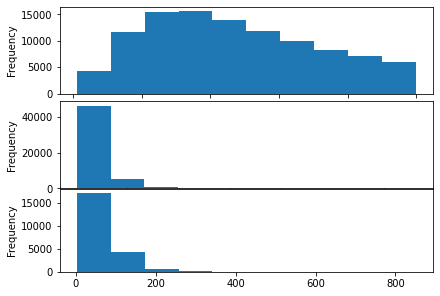

In [20]:
fig, axs = plt.subplots(len(dfs), 1, constrained_layout=True)

for i, ds_name in enumerate(dfs):
    axs[i].set_title(ds_name)
    plt.subplot(len(dfs), 1, i+1)
    dfs[ds_name]["length"].plot(kind='hist',subplots=True,sharex=True,sharey=False)

plt.show()

For preprocessing, we need to do steps like:
* Removing everything inside curly brackets - usually in transcript this is used to describe character's actions or mood - like "(Monika leaves the room)"
* Removing very long phrases - main function of our semantic search service is to find similar long phrases
* Removing very short phrases

In [21]:
dfs["friends"][dfs["friends"]["line"].str.contains('\(')].head(3)

,line,length
17,(mortified) Hi.,15
22,(explaining to the others) Carol moved her stuff out today.,59
24,(to Ross) Let me get you some coffee.,37


In [22]:
for ds_name in dfs:
    remove_curly_brackets = True if ds_name != "main_ds" else 0
    dfs[ds_name] = preproc_df(dfs[ds_name])

semantic-search-service/utils.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["length"] = df[text_col].apply(len)
semantic-search-service/utils.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["length"] = df[text_col].apply(len)
semantic-search-service/utils.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

In [23]:
for ds_name in dfs:
    print(f"Dataset {ds_name} has {len(dfs[ds_name])} lines")
    print(f'Max line length is {max(dfs[ds_name]["length"])}, min line length is {dfs[ds_name]["length"].min()}')
    print(f'Median line length is {dfs[ds_name]["length"].median()}, 99 pct is {dfs[ds_name]["length"].quantile(0.9)}')
    display(dfs[ds_name].head(3))

Dataset main_ds has 103580 lines
Max line length is 100, min line length is 2
Median line length is 44.0, 99 pct is 84.0


,line,length
0,Slightly burnt cheese is great,30
1,Flintstones! Meat the Flintstones!,34
2,#AllPizzaMatters,16


Dataset friends has 47179 lines
Max line length is 150, min line length is 2
Median line length is 40.0, 99 pct is 101.0


,line,length
0,There's nothing to tell! He's just some guy I work with!,56
1,"C'mon, you're going out with the guy! There's gotta be something wrong with him!",80
2,"All right Joey, be nice. So does he have a hump? A hump and a hairpiece?",72


Dataset futurama has 21153 lines
Max line length is 150, min line length is 2
Median line length is 45.0, 99 pct is 106.0


,line,length
0,Space. It seems to go on and on forever. But then you get to the end and the gorilla starts throwing barrels at you.,116
1,And that's how you play the game!,33
2,"You stink, loser!",17


# saving indices and texts to a folder

Our dataset is not so large (~100K) and we could use faiss Flat L2 Index in a reasonable time, but we will use IVFIndex to get a speed up, and choose nprobe and n_clusters not to lose much in quality 

In [24]:
from utils import prepare_artifacts

In [25]:
%cd /content/

/content


In [26]:
save_path = Path("artifacts")
model, data_config, indices = prepare_artifacts(dfs,
                  save_path=save_path,
                  pretrained_model_path=model_fd,
                  text_col="line",
                  model_fd="model",
                  texts_fd="texts",
                  indices_fd="indices",
                  )
assert dfs.keys() == indices.keys()

Copying a model


  0%|          | 0/3 [00:00<?, ?it/s]

Processing main_ds dataset: (1/3)
Calculating embeddings and saving them to faiss index
Processing friends dataset: (2/3)
Calculating embeddings and saving them to faiss index
Processing futurama dataset: (3/3)
Calculating embeddings and saving them to faiss index


# check our indices are working correctly

In [27]:
print(indices.keys())

dict_keys(['main_ds', 'friends', 'futurama'])


In [28]:
from semantic_search import (get_embedder, 
                             retrieve_similar_phrases)

In [29]:
nmodel = get_embedder(save_path / "model")
query_phrase = "What is your job?"

print(f"PHRASE: {query_phrase}")
for ds_name, df in dfs.items():
    print(f"DATASET: {ds_name}")
    similar_phrases = retrieve_similar_phrases(
                             query_phrase,
                             indices[ds_name], 
                             df, 
                             model,
                             top_n=5)    
    display(pd.DataFrame(similar_phrases,
                         columns=["similar_phrases"]))

PHRASE: What is your job?
DATASET: main_ds


,similar_phrases
0,Just being curious. What is your actual job?
1,Just my job!
2,my job is office. i do business.
3,Where do you work? And how do I get there?
4,Where do you work? Are they hiring?


DATASET: friends


,similar_phrases
0,What is your job?
1,"Hey, what kind of work do you do?"
2,"So, um, what do you do for a living?"
3,Where do you work?
4,"Well, what's the job?"


DATASET: futurama


,similar_phrases
0,Cool! What's my job gonna be?
1,This is unbelievable! What do you heads do all day?
2,I love this job.
3,What business is it of yours?
4,"Prepare for pleasantries. So Fry, what do you do for a living?"


# zip and upload artifacts to s3 bucket

In [31]:
%%time
artifacts_zip_name = save_path.name + ".zip"

# to not save root folder in zip but only contents
%cd {save_path}
!zip -r {artifacts_zip_name} ./* -x "*/.*" # not saving hidden files
%cd /content/
!mv {save_path / artifacts_zip_name} .

!du -h {artifacts_zip_name}

/content/artifacts
  adding: data_config.json (deflated 73%)
  adding: indices/ (stored 0%)
  adding: indices/faiss_index_friends.pkl (deflated 7%)
  adding: indices/faiss_index_main_ds.pkl (deflated 7%)
  adding: indices/faiss_index_futurama.pkl (deflated 7%)
  adding: model/ (stored 0%)
  adding: model/modules.json (deflated 62%)
  adding: model/README.md (deflated 63%)
  adding: model/pytorch_model.bin (deflated 8%)
  adding: model/config_sentence_transformers.json (deflated 27%)
  adding: model/tokenizer_config.json (deflated 46%)
  adding: model/sentence_bert_config.json (deflated 4%)
  adding: model/special_tokens_map.json (deflated 46%)
  adding: model/vocab.txt (deflated 53%)
  adding: model/tokenizer.json (deflated 59%)
  adding: model/data_config.json (deflated 92%)
  adding: model/1_Pooling/ (stored 0%)
  adding: model/1_Pooling/config.json (deflated 47%)
  adding: model/config.json (deflated 46%)
  adding: model/train_script.py (deflated 71%)
  adding: texts/ (stored 0%)
  

In [36]:
%%time
my_bucket.upload_file(artifacts_zip_name, artifacts_zip_name)

CPU times: user 5.69 s, sys: 3.41 s, total: 9.1 s
Wall time: 8.83 s


In [37]:
for my_bucket_object in my_bucket.objects.all():
    print(my_bucket_object)

s3.ObjectSummary(bucket_name='semantic-search-oct21', key='artifacts.zip')
s3.ObjectSummary(bucket_name='semantic-search-oct21', key='friends_quotes.csv')
s3.ObjectSummary(bucket_name='semantic-search-oct21', key='futurama_quotes.csv')
s3.ObjectSummary(bucket_name='semantic-search-oct21', key='phrases.txt.gz')
